# How to extract and combine the data and create a unified time series dataset

In [4]:
This code snippet is designed to clear out existing data and plots in specific directories. Here's a breakdown of what it does:
# # clear out the existing data and plots
# import os

# base_dir = os.path.dirname(os.path.realpath('./protocols/04032024_usda_rice'))
# dirs = ['output_data', 'output_plots', 'output_protocol', 'scripts']
# for d in dirs:
#     if os.path.exists(d):
#         for f in os.listdir(d):
#             os.remove(os.path.join(d, f))
#     else:
#         os.makedirs(d)

## Load the libraries, and defines LED names

In [1]:
%pip install pytz pandas numpy seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import os
import glob
from typing import List, Dict, Tuple
import re

# for the date and time, parsing from json metadata into a filename for export
from datetime import datetime
import pytz

# Data processing
import pandas as pd  # for dataframes, data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np  # for linear algebra, arrays, operations on numerical tables and matrices

# Visualization
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # for making plots with seaborn

# dict for translating the light number to a string
light_dict = {
    0: "dark",
    1: "530nm",
    2: "655nm",
    3: "590nm",
    4: "448nm",
    5: "950nm",
    6: "950nm",
    7: "655nm",
    8: "850nm",
    9: "730nm",
    10: "820nm",
}

In [3]:
file_number = 5

## Define the functions we will use

In [4]:
def get_experiment_name(filename: str) -> str:
    """
    Take an experiment datafile and parse the experiment name from the file metadata
    into a string in the form of:
    '%Y%M%D_experiment_name'
    If experiment = testMacro, name = 012424_leaf_fr150_fr0SP, and created_at = 2024-01-25T00:58:36.782Z
    then the function should return:
    '20240125_testMacro_012424_leaf_fr150_fr0SP'
    """

    with open(filename) as file:
        obj = json.load(file)[0]

    experiment = obj["experiment"]
    name = re.sub(r"\d{6}(_)+", "", obj["name"])
    created_at = obj["created_at"]

    # Convert the timestamp to datetime object
    dt = datetime.strptime(created_at, "%Y-%m-%dT%H:%M:%S.%fZ")

    # Set the timezone to UTC
    dt = dt.replace(tzinfo=pytz.UTC)

    # Convert the datetime object to PST
    dt_pst = dt.astimezone(pytz.timezone("US/Pacific"))

    # Format the datetime object as a string
    created_at_pst = dt_pst.strftime("%Y%m%d")

    print(f"experiment: {experiment}, name: {name}, created_at: {created_at_pst}")

    return created_at_pst + "_" + experiment + "_" + name


#### parse the varray into a dict for reference, with the various codes of the varray reference
### returning the values they represent when we query the varray.
### Eg varray["@n4:0"] = "820nm"
def parse_varray(vArrayDict) -> Dict:
    """dict, extract the parts we need and parse them into a dict for reference"""
    parsed = {}
    for i in range(len(vArrayDict)):
        for j in range(len(vArrayDict[i])):
            parsed[f"@n{i}:{j}"] = vArrayDict[i][j]
    return parsed


def get_data_from_file(file_path: str) -> Dict:
    print(f"Attempting to load data from : {file_path}")
    with open(filename) as file:
        root = json.load(file)

    ########################## get the data set ###############################
    # does the data_set exist? check to see if it is nested in data, or just exposed as sample
    try:
        data_set = root[0]["data"]["sample"][0]["set"]
    except KeyError:
        try:
            data_set = root[0]["sample"][0]["set"]
        except KeyError:
            data_set = "blank"

    if data_set == "blank":
        print("no data set found")
    else:
        print("Data found, returning data_set with length: ", len(data_set))

    # sort data_set by time
    data_set = sorted(data_set, key=lambda k: k["time"])

    return data_set


def get_protocol_from_file(file_path: str) -> Dict:
    print(f"Attempting to load protocol from : {file_path}")
    with open(file_path) as file:
        root = json.load(file)

    protocolStr = root[0]["protocol"]

    try:
        # parse the json string into a dict
        protocol_dict = json.loads(protocolStr)[0]
    except TypeError:
        print("protocol is not a string, skipping")

    return protocol_dict


def parse_vlist(vlist: List[str], varray: dict) -> List[int]:
    parsed = []
    for item in vlist:
        if type(item) != str:
            parsed.append(int(item))
        else:
            parsed.append(int(varray[item]))
    return parsed


def getProtocolForLabel(label: str, protocols: dict) -> dict:
    protocolList = protocols["_protocol_set_"]
    for protocol in protocolList:
        if protocol["label"] == label:
            return protocol
    return None


# extract all of the start times for each trace in the protocol script, and calculate
# the time in milliseconds from the beginning of the experiment
# This allows us to create an accurate time series for the data
def get_experiment_start_times_ms(filename: str) -> dict:
    with open(filename) as file:
        root = json.load(file)[0]

    # The object may be nested in a "data" object, or just exposed as "sample"
    try:
        data = root["data"]
    except KeyError:
        data = root

    experiment_start_time = int(data["time"])
    time_dict = {"experiment_start": experiment_start_time}
    time_list = []

    for i, protocol in enumerate(data["sample"][0]["set"]):
        time_list.append(
            {
                "label": protocol["label"],
                "time_ms": (int(protocol["time"]) - experiment_start_time),  # in ms
            }
        )

    time_dict["protocol_times"] = time_list
    return time_dict


def convert_epoch_ms_to_datetime(epoch: int) -> datetime:
    return datetime.fromtimestamp(epoch / 1000.0)

    # create a time axis, using the protocol of the experiment. Values for pulse distance are


# in microseconds, so we need to convert them to milliseconds
def create_time_axis(label: str, iter: int, experiment_dict: dict) -> list:
    time_axis = []
    protocol_times = experiment_dict["time_dict"]["protocol_times"]
    protocolScript = getProtocolForLabel(label, experiment_dict["protocols"])
    print(f"protocolScript: {protocolScript}")

    if protocol_times[iter]["label"] != label:
        print(f"label mismatch: {protocol_times[iter]['label']} != {label}")
        return None
    print(f"protocol_times: {protocol_times}")

    pulses = parse_vlist(protocolScript["pulses"], experiment_dict["varray"])
    print(f"pulses: {pulses}")

    pulse_distance_us = parse_vlist(
        protocolScript["pulse_distance"], experiment_dict["varray"]
    )
    print(f"pulse_distance_us: {pulse_distance_us}")

    pulse_distance_ms = [x / 1000 for x in pulse_distance_us]
    print(f"pulse_distance_ms: {pulse_distance_ms}")

    trace_start_ms = protocol_times[iter]["time_ms"]
    print(f"trace_start_ms: {trace_start_ms}")

    # i for each unit of pulses, [500, 500, 500] for a 1500 pulse experiment
    # Each unit of pulses has a corresponding pulse_distance [1000, 1000, 1000] would be 1 ms pulse distance
    # We converted the us pulse distance to ms above, so we don't have to do it here
    last_time_point = trace_start_ms
    for i in range(len(pulses)):
        # j for each pulse in the range i of pulses, ex 0:500 for the first 500 pulses
        for j in range(pulses[i]):
            current_time_point = round(last_time_point + pulse_distance_ms[i], 4)
            time_axis.append(current_time_point)
            last_time_point = current_time_point

    print(f"time_axis: {time_axis}")

    if len(time_axis) != sum(pulses):
        print(f"length of time axis: {len(time_axis)} != sum of pulses: {sum(pulses)}")
        return None

    return time_axis


def deinterpolate_data(data: list, protocol: dict) -> dict:
    """
    Takes in a list of data and a protocol dict, and then deinterpolates it into a list of lists, where each list
    is a trace of data from a single light source. Then concatenates the lists into a single list
    of values, and returns it in a dict along with the lednums so you can tell which light source the data came from.
    """
    pulsed_lights = protocol.get("pulsed_lights", 0)
    pulse_phases = protocol.get("pulses", 0)

    # exit early if there are no pulsed lights or pulse phases
    if pulsed_lights == 0 or pulse_phases == 0:
        return None

    num_pulsed_leds = len(pulsed_lights[0])

    # exit early if there is only one light, no need to deinterpolate
    print(f"num_pulsed_leds: {num_pulsed_leds}")
    if num_pulsed_leds == 1:
        lednums = [pulsed_lights[0][0] for i in range(len(data))]
        return {"values": data, "lednums": lednums}

    total_pulses = num_pulsed_leds * sum(pulse_phases)

    print(f"num_pulsed_leds: {num_pulsed_leds}, total_pulses: {total_pulses}")

    # so now we can verify that our number is equal to the length of the data list
    if total_pulses != len(data):
        print(f"total_pulses: {total_pulses} != len(data): {len(data)}")
        return None

    # if the number of pulses is equal to the length of the data list, then we can
    # deinterpolate the data into a list of lists, where each list is a trace of data
    # from a single light source
    deinterpolated_data = [[] for i in range(num_pulsed_leds)]
    print(
        f"deinterpolated_data: {len(deinterpolated_data)}, num_pulsed_leds: {num_pulsed_leds}"
    )

    for i in range(total_pulses):
        # the order of the points is repeated, like: 0, 1, 0, 1, 0, 1, 0, 1, 0, 1
        # so if i is 0, 2, 4, 6, 8, then we append that datapoint to the first list
        # if i is 1, 3, 5, 7, 9, then we append that datapoint to the second list
        if num_pulsed_leds == 1:
            deinterpolated_data[0].append(data[i])
            continue

        if i % 2 == 0:
            deinterpolated_data[0].append(data[i])
        else:
            deinterpolated_data[1].append(data[i])

    print(
        f"len(deinterpolated_data[0]): {len(deinterpolated_data[0])}, len(deinterpolated_data[1]): {len(deinterpolated_data[1])}"
    )

    # The length of each of those lists should be equal to the total_pulses / num_pulsed_leds
    if len(deinterpolated_data[0]) != total_pulses / num_pulsed_leds:
        print(
            f"len(deinterpolated_data[0]): {len(deinterpolated_data[0])} != total_pulses / num_pulsed_leds: {total_pulses / num_pulsed_leds}"
        )
        return None

    # concatenate the lists into a single list of values, with the first list first, and the second list second
    concatenated_data = deinterpolated_data[0] + deinterpolated_data[1]

    print(f"len(concatenated_data): {len(concatenated_data)}")

    concatenated_lednums = [pulsed_lights[0][0] for i in deinterpolated_data[0]] + [
        pulsed_lights[0][1] for i in deinterpolated_data[1]
    ]

    # return a dict of the concatenated data and the concatenated lednums
    return {"values": concatenated_data, "lednums": concatenated_lednums}


def convert_led_nums_to_wavelength(lednums: list) -> list:
    return [light_dict[i] for i in lednums]


def create_df(iter: int, data: dict, experiment_dict: dict) -> pd.DataFrame:
    """
    This function will take in a data dict, and then figure out if it is a single trace or a multi-trace
    experiment. It will then create a pandas dataframe from the data, and return it.

    The "data_raw" will need to be split into its individual parts, and then a time axis will be created
    that can be applied to both parts.

    There will be a shared time axis and value column, with each trace having a wavelength column that lists
    the measuring light used was.

    params:
    iter: int, the index of the protocol in the experiment_dic
    data: dict, the data from the experiment
    experiment_dict: dict, the dict containing the experiment data parameters, like the protocols, varray, etc.

    returns:
    pd.DataFrame, a dataframe of the data from the experiment like: labels, time_ms, wavelength, value, experiment_name, trace_num
    """
    print(f"creating dataframe for {data['label']}, trace {iter}")
    protocolScript = getProtocolForLabel(d["label"], experiment_dict["protocols"])

    data_raw = deinterpolate_data(data["data_raw"], protocolScript)

    if data_raw == None:
        print(f"deinterpolate_data returned None for {d['label']}, trace {i}")
        return None

    values = data_raw["values"]

    wavelength = convert_led_nums_to_wavelength(data_raw["lednums"])

    labels = [d["label"] for j in range(len(values))]

    time_ms = create_time_axis(d["label"], iter, experiment_dict)

    trace_num = [i for j in range(len(d["data_raw"]))]

    print(f"creating dataframe for {d['label']}, trace {iter}")

    print(
        f"len(values): {len(values)}, len(labels): {len(labels)}, len(time_ms): {len(time_ms)}"
    )

    if len(time_ms) != len(values):
        time_ms = time_ms + time_ms

    print(len(time_ms), len(values))

    # adjust the time_ms to start at 0
    trace_start = min(time_ms)
    time_ms_trace = [t - trace_start for t in time_ms]

    data_dict = {
        "labels": labels,
        "time_ms": time_ms,
        "time_ms_trace": time_ms_trace,
        "wavelength": wavelength,
        "value": values,
        "experiment_name": experiment_name,
        "trace_num": trace_num,
    }

    return pd.DataFrame(data_dict)


def get_true_zero(df: pd.DataFrame) -> int:
    # get the mean of the values in which the labels fields includes "trueZero"
    # trueZero_noSP_noML_noActinic
    trueZero = df[p700_df["labels"].str.contains("trueZero")]["value"].mean()
    print(f"trueZero: {trueZero}")
    return trueZero


def calculate_fvfm(df: pd.DataFrame, true_zero: int) -> float:
    # Calculate Fv/Fm
    # Fv = Fm - Fo
    # Fm = max fluorescence
    # Fo = minimal fluorescence
    # Fv/Fm = (Fm - Fo) / Fm    # Fo is the minimal fluorescence measured in the dark-adapted state

    # subtract the offset from true zero, and calculate the mean of the values

    Fo = df.iloc[25:30]["value"].mean() - true_zero
    Fm = df.iloc[40:50]["value"].mean() - true_zero

    print(f"Fo: {Fo}, Fm: {Fm}")

    return round((Fm - Fo) / Fm, 2)  # two decimal places is fine

# Load the data and protocol details

In [4]:
import glob


files = glob.glob("data/*.json")

files = [filename for filename in files if "4193" in filename]

print(files)

['data\\4193_1_DA_Y.json', 'data\\4193_2_DA_Y.json', 'data\\4193_3_DA_Y.json']


In [ ]:
file_number =

with open(filename) as file:

    root = json.load(file)[0]

print(f"Filename: {filename}")
# whats the current status of this ovject? any keys?
print(root.keys())


time_dict = get_experiment_start_times_ms(filename)
print(time_dict)

In [6]:

# get the data from the file and parse it into a dict, or return "blank"
time_dict = get_experiment_start_times_ms(filename)
start = time_dict["experiment_start"]
data_set = get_data_from_file(filename)
protocol_dict = get_protocol_from_file(filename)
experiment_name = get_experiment_name(filename)
try:
    varray = parse_varray(protocol_dict["v_arrays"])
except KeyError:
    print("no varray found")
    varray = None

# create a dict to hold all the experiment data and parameters
experiment_dict = {
    "data_set": data_set,
    "protocols": protocol_dict,
    "experiment_name": experiment_name,
    "experiment_date": experiment_name[:8],
    "experiment": experiment_name[9:],
    "varray": varray,
    "start_time": start,
    "time_dict": time_dict,
    "true_zero": -156
}
print(experiment_dict["time_dict"])
print(experiment_name)
print(experiment_dict["protocols"])
print(experiment_dict["experiment"])
print(experiment_dict["experiment_date"])


Attempting to load data from : data\4191#2_3_DA_Y.json
Data found, returning data_set with length:  15
Attempting to load protocol from : data\4191#2_3_DA_Y.json
experiment: 0514maize, name: 4191#2_3_DA_Y, created_at: 20240514
{'experiment_start': 1715719901083, 'protocol_times': [{'label': 'p700_reference', 'time_ms': 22}, {'label': 'fluor_reference', 'time_ms': 1333}, {'label': 'fvfm', 'time_ms': 2650}, {'label': 'artifact', 'time_ms': 3966}, {'label': 'Preillum_at_600_for_300s', 'time_ms': 5275}, {'label': 'Preillum_at_1700_for_60s', 'time_ms': 305482}, {'label': 'p700_1700', 'time_ms': 365514}, {'label': 'Preillum_at_250_for_60s', 'time_ms': 368140}, {'label': 'p700_250', 'time_ms': 428194}, {'label': 'Preillum_at_1000_for_60s', 'time_ms': 430820}, {'label': 'p700_1000', 'time_ms': 490873}, {'label': 'Preillum_at_500_for_60s', 'time_ms': 493499}, {'label': 'p700_500', 'time_ms': 553545}, {'label': 'Preillum_9_250_15s', 'time_ms': 556170}, {'label': 'p700_PMAX', 'time_ms': 571172}]}

## Process the data and create the unified time series dataset

In [7]:
# create an empty dataframe
df = pd.DataFrame()

for i, d in enumerate(data_set):
    d_df = create_df(i, d, experiment_dict)
    if d_df is None:
        print(f"create_df returned None for {d['label']}, trace {i}")
        continue

    # check to see that the time_axis is a sequential list of numbers
    if (np.diff(d_df["time_ms"]) > 0).all():
        print("time axis is sequential")
    else:
        print("time axis is not sequential")

    print(d_df.head())

    # concatenate the dataframes
    df = pd.concat([df, pd.DataFrame(d_df)], ignore_index=True)

df["time_s"] = round(df["time_ms"] / 1000, 6)

print(df.head())
print(df.tail())

# adjust for true zero, at -156
df["value"] = df["value"].apply(lambda x: x - experiment_dict["true_zero"])


# remove all the "Preillum" labels, we don't need them
df = df[~df["labels"].str.contains("Preillum")]


# save the data to disk
df.to_csv(f"output_data/{experiment_name}.csv")

# export the protocol to a json file
with open(f"output_protocol/{experiment_name}_protocol.json", "w") as file:
    json.dump(protocol_dict, file)

creating dataframe for p700_reference, trace 0
num_pulsed_leds: 1
protocolScript: {'label': 'p700_reference', 'pulses': [100, 50, 100], 'pulse_distance': [5000, 5000, 5000], 'pulsed_lights': [[10], [10], [10]], 'pulsed_lights_brightness': [['@n1:0'], ['@n1:0'], ['@n1:0']], 'pulse_length': [['@n1:1'], ['@n1:1'], ['@n1:1']], 'nonpulsed_lights': [[2, 4], [2, 4], [2, 4]], 'nonpulsed_lights_brightness': [[0, 0], [0, 0], [0, 0]], 'detectors': [[1], [1], [1]], 'protocol_averages': 1, 'protocol_repeats': 1, 'measurements_delay': 0}
protocol_times: [{'label': 'p700_reference', 'time_ms': 22}, {'label': 'fluor_reference', 'time_ms': 1333}, {'label': 'fvfm', 'time_ms': 2650}, {'label': 'artifact', 'time_ms': 3966}, {'label': 'Preillum_at_600_for_300s', 'time_ms': 5275}, {'label': 'Preillum_at_1700_for_60s', 'time_ms': 305482}, {'label': 'p700_1700', 'time_ms': 365514}, {'label': 'Preillum_at_250_for_60s', 'time_ms': 368140}, {'label': 'p700_250', 'time_ms': 428194}, {'label': 'Preillum_at_1000_fo

In [92]:
# # # okay, so we can parse the labels into a dict, and then use that to create new columns in the dataframe
# # for each of the values in the dict
# def parse_label_to_variables_dict(label: str) -> dict:
#     label = label.split("_")
#     return {label[i]: label[i + 1] for i in range(0, len(label), 2)}

# # test it out
# df = pd.read_csv(f"output_data/{experiment_name}.csv")

# # now create columns for each of the values in the dict
# df = pd.concat([df, df["labels"].apply(parse_label_to_variables_dict).apply(pd.Series)], axis=1)

# # rename the wl column to "target_wl"
# df.rename(columns={"wl": "target_wl"}, inplace=True)

# print(df.head())
# df.to_csv(f"output_data/{experiment_name}.csv")

data.columns= Index(['Unnamed: 0', 'labels', 'time_ms', 'time_ms_trace', 'wavelength',
       'value', 'experiment_name', 'trace_num', 'time_s'],
      dtype='object')


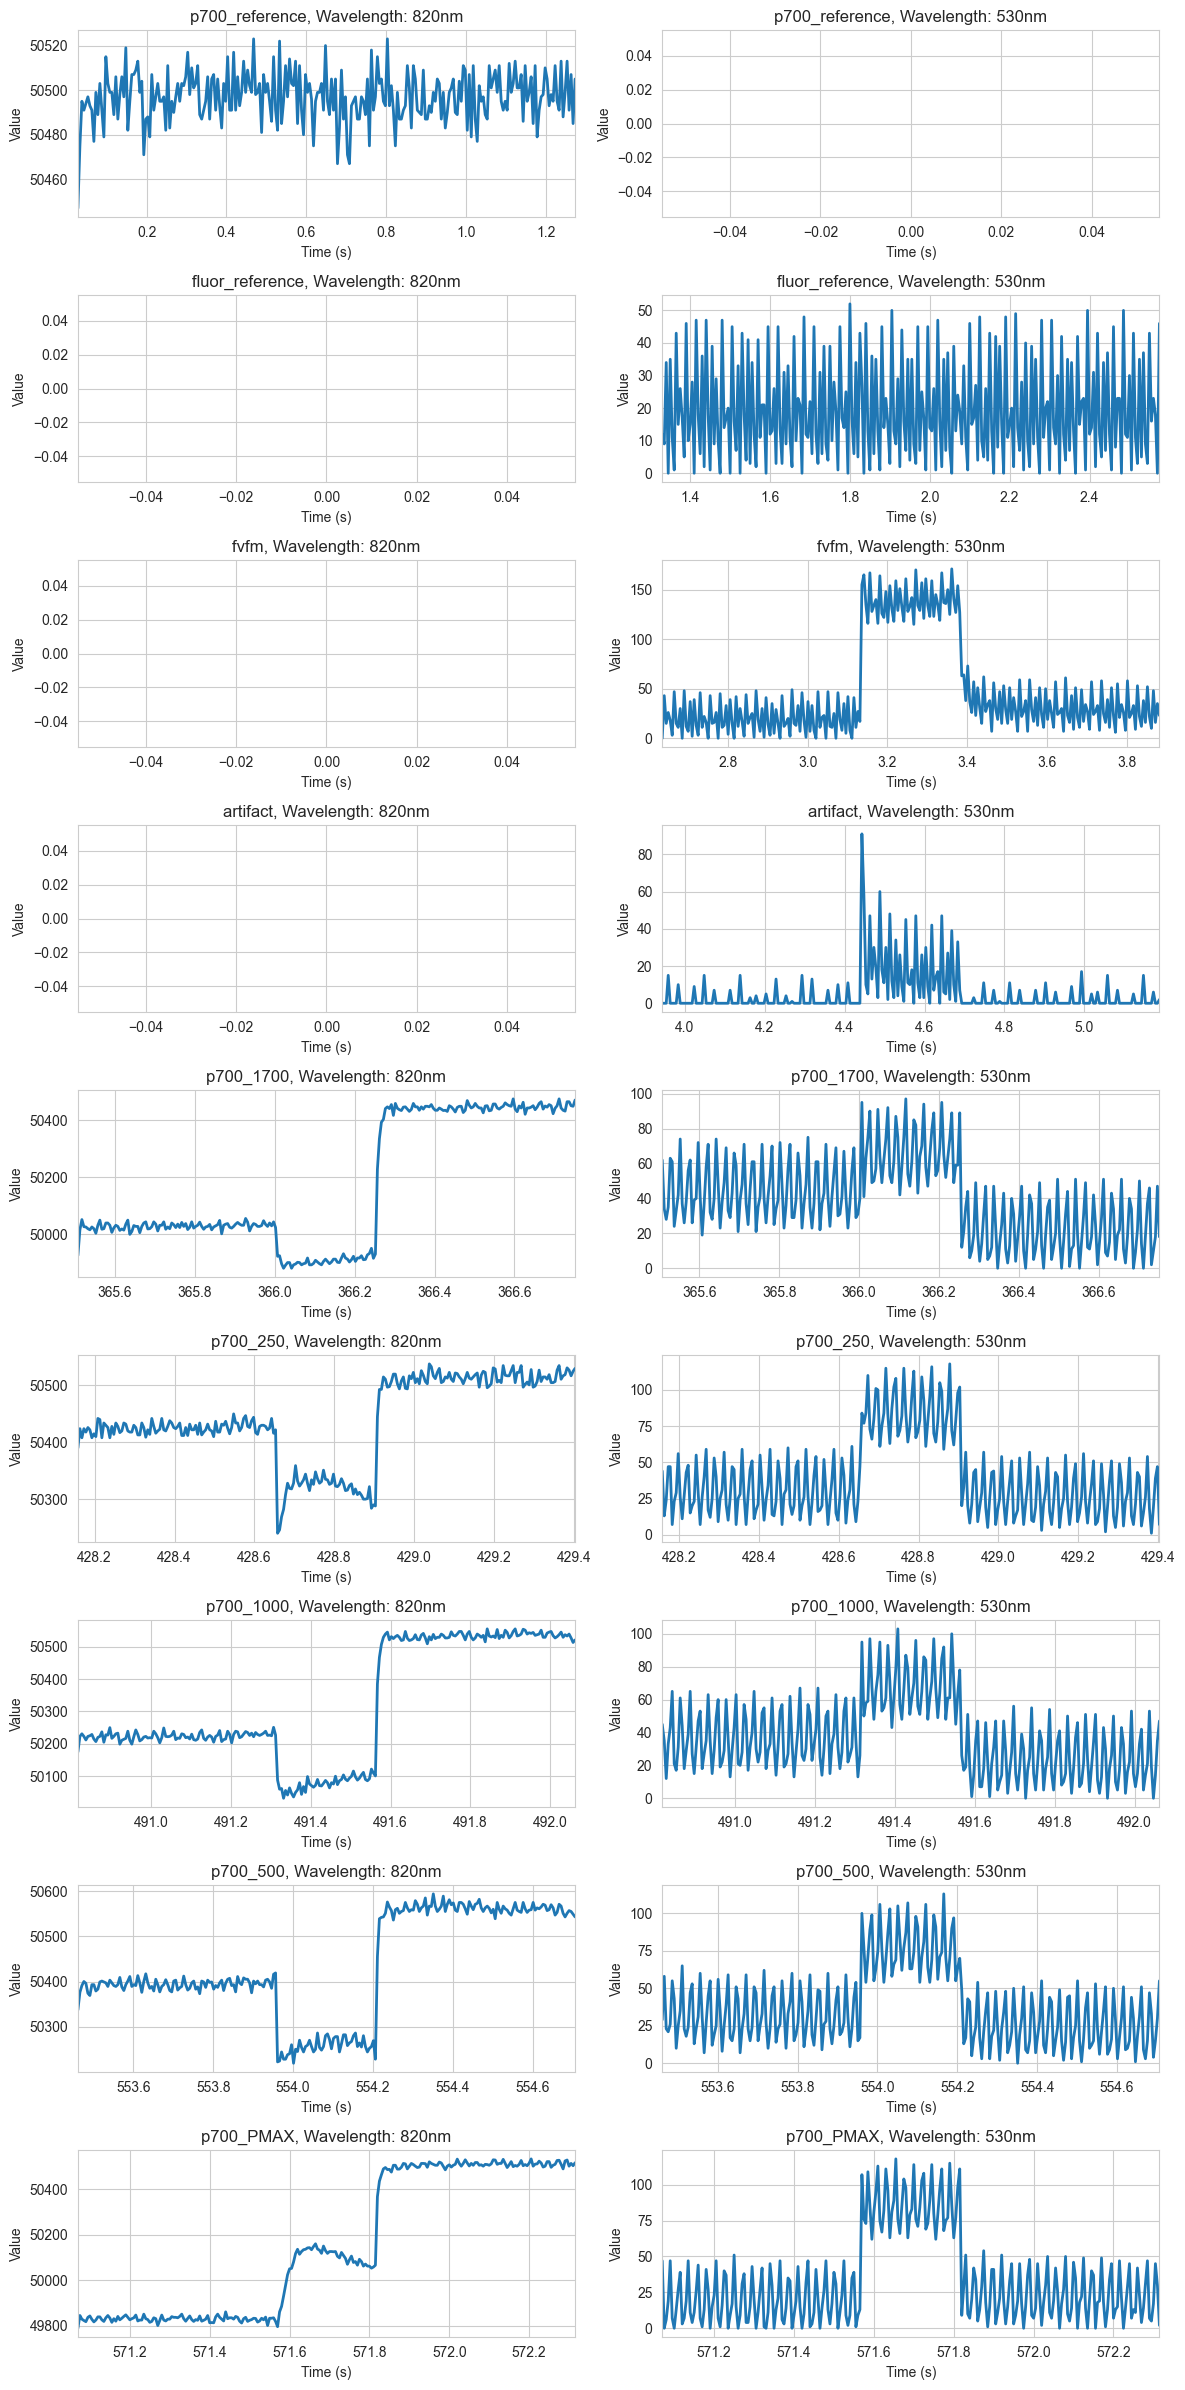

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(f"output_data/{experiment_name}.csv")

print(f"data.columns= {data.columns}")

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Identify unique labels and wavelengths in the dataset
unique_labels = data["labels"].unique()
unique_wavelengths = data["wavelength"].unique()

unique_labels, unique_wavelengths

# Create a figure to hold the adjusted plots
fig, axes = plt.subplots(len(unique_labels), 2, figsize=(12, 24), sharex=False)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Loop through each label and wavelength to create adjusted plots
for i, label in enumerate(unique_labels):
    for j, wavelength in enumerate(unique_wavelengths):
        # Filter the data for the current label and wavelength
        filtered_data = data[
            (data["labels"] == label) & (data["wavelength"] == wavelength)
        ]

        # Plot value over time with adjusted x-axis
        sns.lineplot(
            ax=axes[i, j],
            x="time_s",
            y="value",
            data=filtered_data,
            linestyle="-",
            linewidth=2
        )

        # Set the title and labels
        axes[i, j].set_title(f"{label}, Wavelength: {wavelength}")
        axes[i, j].set_xlabel("Time (s)")
        axes[i, j].set_ylabel("Value")

        # Adjust the x-axis to show only the range with data
        if not filtered_data.empty:
            min_time = filtered_data["time_s"].min()
            max_time = filtered_data["time_s"].max()
            axes[i, j].set_xlim(min_time, max_time)

# Adjust layout to make room for titles and labels
plt.tight_layout()

# Show the adjusted plots
plt.show()

## P700 data over time

p700_min: 49689, p700_max: 50837.59654
['p700_reference', 'p700_PMAX', 'p700_250', 'p700_500', 'p700_1000', 'p700_1700']
Fo: 19.822222222222223, Fm: 139.1, Fv/Fm: 0.86
pmax: 50084.75
Fo: nan, Fm: nan, Fv/Fm: nan
Fo: 29.2, Fm: 86.7, Fv/Fm: 0.66
Fo: 31.866666666666667, Fm: 76.25, Fv/Fm: 0.58
Fo: 36.91111111111111, Fm: 68.65, Fv/Fm: 0.46
Fo: 44.31111111111111, Fm: 68.15, Fv/Fm: 0.35


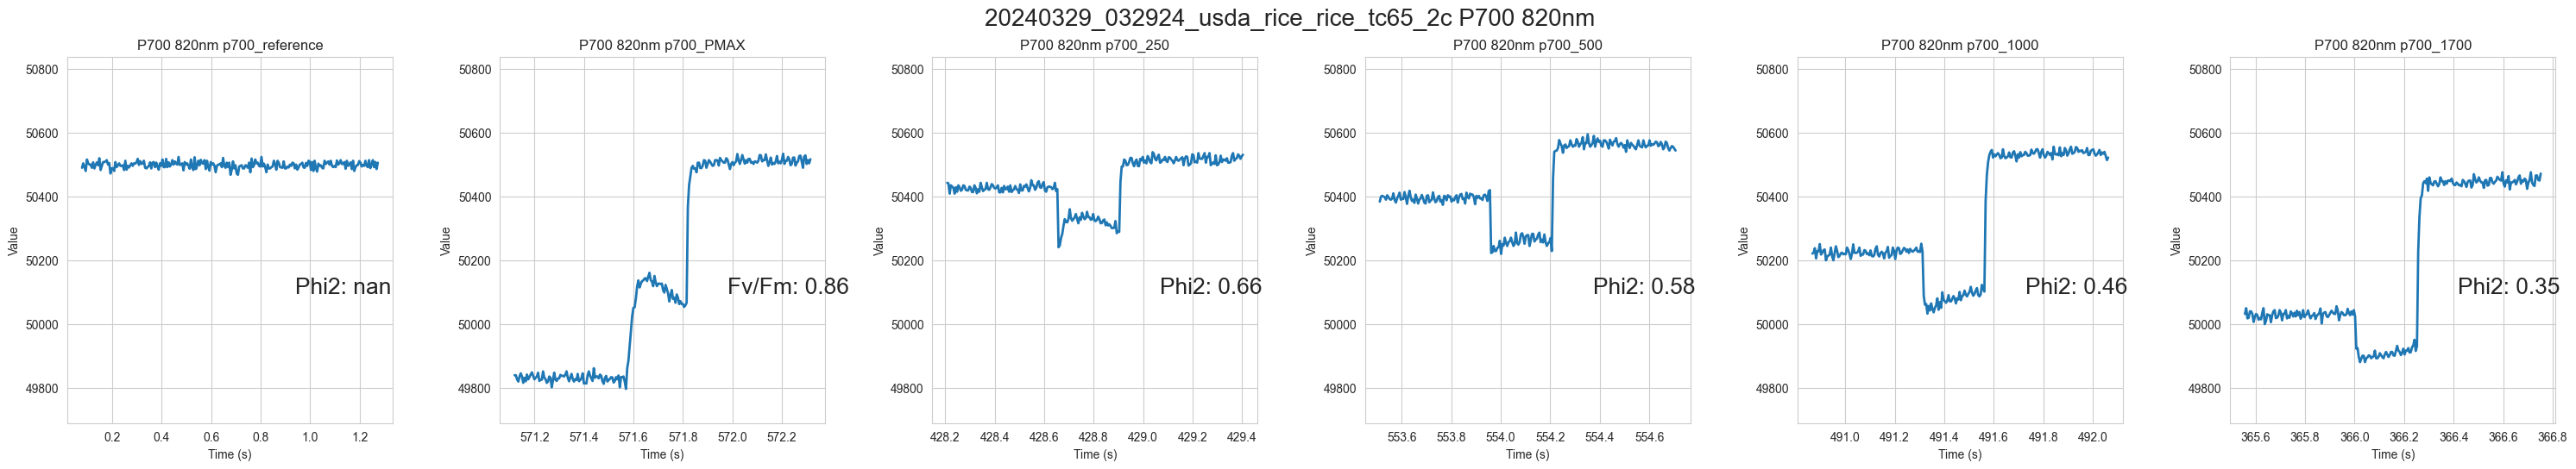

              0
reference   NaN
fvfm       0.86
250        0.66
500        0.58
1000       0.46


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns


def calculate_fvfm(data, pulse_start, pulse_end):
    # Calculate Fv/Fm
    # Fv = Fm - Fo
    # Fm = max fluorescence
    # Fo = minimal fluorescence
    # Fv/Fm = (Fm - Fo) / Fm    # Fo is the minimal fluorescence measured in the dark-adapted state

    # halfway through the pulse,
    pulse_midpoint = pulse_start + ((pulse_end - pulse_start) // 2)
    prepulse_midpoint = pulse_start // 2

    # reindex the data
    data = data.copy().reset_index(drop=True)

    Fo = data.iloc[prepulse_midpoint : pulse_start - 5]["value"].mean()
    Fm = data.iloc[pulse_midpoint : pulse_end - 5]["value"].mean()
    FvFm = round((Fm - Fo) / Fm, 2)
    print(f"Fo: {Fo}, Fm: {Fm}, Fv/Fm: {FvFm}")

    return round((Fm - Fo) / Fm, 2)  # two decimal places is fine


data_p700 = pd.read_csv(f"output_data/{experiment_name}.csv")
true_zero = 0


# Filter by wavelength
data_fluor = data_p700[data_p700["wavelength"] == "530nm"]
data_p700 = data_p700[data_p700["wavelength"] == "820nm"]

# get the mean, max and min of the values
p700_min, p700_max, p700_mean = data_p700["value"].min(), data_p700["value"].max(), data_p700["value"].mean()

# p700 min is the max of either the min value, or the mean * 0.99
p700_min = min(p700_min - 100, p700_mean * 0.99)

# p700 max is the min of either the max value, or the mean * 1.01
p700_max = max(p700_max + 100, p700_mean * 1.01)

print(f"p700_min: {p700_min}, p700_max: {p700_max}")

# get unique trace labels
sorted_labels = sorted(data_p700["labels"].unique())
unique_labels = []

# we want the reference first, then pmax, then the rest in order of the numver after "p700_"
# reference is last, so we pop it and insert it at the beginning
unique_labels.insert(0, sorted_labels.pop())

# now we want to pop the pmax and insert it at the beginning, after the reference
unique_labels.insert(1, sorted_labels.pop())

# now the first two are in the right order, but the others are not.
# we want to sort the rest of the labels by the number after "p700_"
sorted_labels = sorted(sorted_labels, key=lambda x: int(x.split("_")[-1]))

# now we want to insert the sorted labels into the unique_labels list, after the pmax
for label in sorted_labels:
    unique_labels.append(label)
    
print(unique_labels)

# get fvfm from the fvfm trace, for the max value
fvfm = calculate_fvfm(data_fluor[data_fluor["labels"] == "fvfm"], 100, 150)

# get the pmax, and calculate the maximum value during the pulse
pmax = data_p700[data_p700["labels"] == "p700_PMAX"]
pmax = pmax.iloc[-150:140]["value"].mean()

print(f"pmax: {pmax}")

# plot the data
plt.figure(figsize=(30, 10))

fluor_data = {}

for i, label in enumerate(unique_labels):
    ax = plt.subplot(2, len(unique_labels), i + 1)

    label_data = data_p700[data_p700["labels"] == label]
    label_data = label_data.iloc[10:]

    if "PMAX" in label:
        text_annotation = f"Fv/Fm: {fvfm}"
        fluor_data["fvfm"] = fvfm        
    else:
        phi2 = calculate_fvfm(data_fluor[data_fluor["labels"] == label], 100, 150)
        text_annotation = f"Phi2: {phi2}"
        fluor_data[label.split("_")[-1]] = phi2

    sns.lineplot(x="time_s", y="value", data=label_data, linestyle="-", linewidth=2)
    ax.set_title(f"P700 820nm {label}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Value")
    ax.text(
        0.7,
        0.4,
        text_annotation,
        transform=ax.transAxes,
        fontsize=19,
        verticalalignment="top",
    )
    
    ax.set_ylim(p700_min, p700_max)


plt.suptitle(f"{experiment_name} P700 820nm", fontsize=20)

plt.tight_layout()
plt.savefig(f"output_plots/{experiment_name}_820nm.png")

plt.show()

# export the fluor_data dict  as a dataframe and save to csv
# the dict should be a column marked "ue" with the labels as the index, and the values as the values
fluor_df = pd.DataFrame(fluor_data, index=[0])
fluor_df.to_csv(f"output_data/{experiment_name}_fluor.csv")
print(fluor_df.transpose().head())

### Calculation of the P700 values Pm, Pm', P, and P0
calculate dAbs for the traces

In [95]:
%pip install scikit-learn 

from sklearn.linear_model import LinearRegression
from typing import Tuple
import numpy as np
import pandas as pd

def calc_linear_regression(x: np.array, y: np.array) -> Tuple[float, float]:
    # Create a DataFrame from the input arrays
    df = pd.DataFrame({"time_s": x, "dAbs": y})

    # Apply a rolling mean to the 'dAbs' column
    window_size = 5
    df["dAbs"] = df["dAbs"].rolling(window=window_size, center=True).mean()

    # Drop rows with NaN values
    df = df.dropna()

    # Fit a linear regression model
    lm = LinearRegression().fit(df["time_s"].values.reshape(-1, 1), df["dAbs"].values)

    # Extract the slope and intercept
    slope = lm.coef_[0]
    intercept = lm.intercept_

    return slope, intercept

def calc_delta_absorbance(transmission: np.array, baseline_value: float) -> np.array:
    """Calculates delta absorbance for p700 data using a given baseline."""
    return (transmission / baseline_value) / (-1 / 2.3)

# Function to calculate baseline for a specific label
def calculate_baseline_for_label(data: pd.DataFrame, begin: int = -50, end: int = -1) -> float:
    """Calculates the baseline absorbance for a given label."""
    transmission = data["value"].values
    baseline_value = np.mean(transmission[begin:end])
    return baseline_value

def calculate_fvfm(data, pulse_start, pulse_end):
    # halfway through the pulse,
    pulse_midpoint = pulse_start + ((pulse_end - pulse_start) // 2)
    prepulse_midpoint = pulse_start // 2

    # reindex the data
    data = data.copy().reset_index(drop=True)

    Fo = data.iloc[prepulse_midpoint : pulse_start - 5]["value"].mean()
    Fm = data.iloc[pulse_midpoint : pulse_end - 5]["value"].mean()
    FvFm = round((Fm - Fo) / Fm, 2)

    return round((Fm - Fo) / Fm, 2)  # two decimal places is fine


Note: you may need to restart the kernel to use updated packages.


247
247
247
247
247


C:\Users\magnus.wood\AppData\Local\Temp\ipykernel_32424\3935173688.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_p700.loc[data_p700["labels"] == label, "dAbs"] = label_data["dAbs"]


247


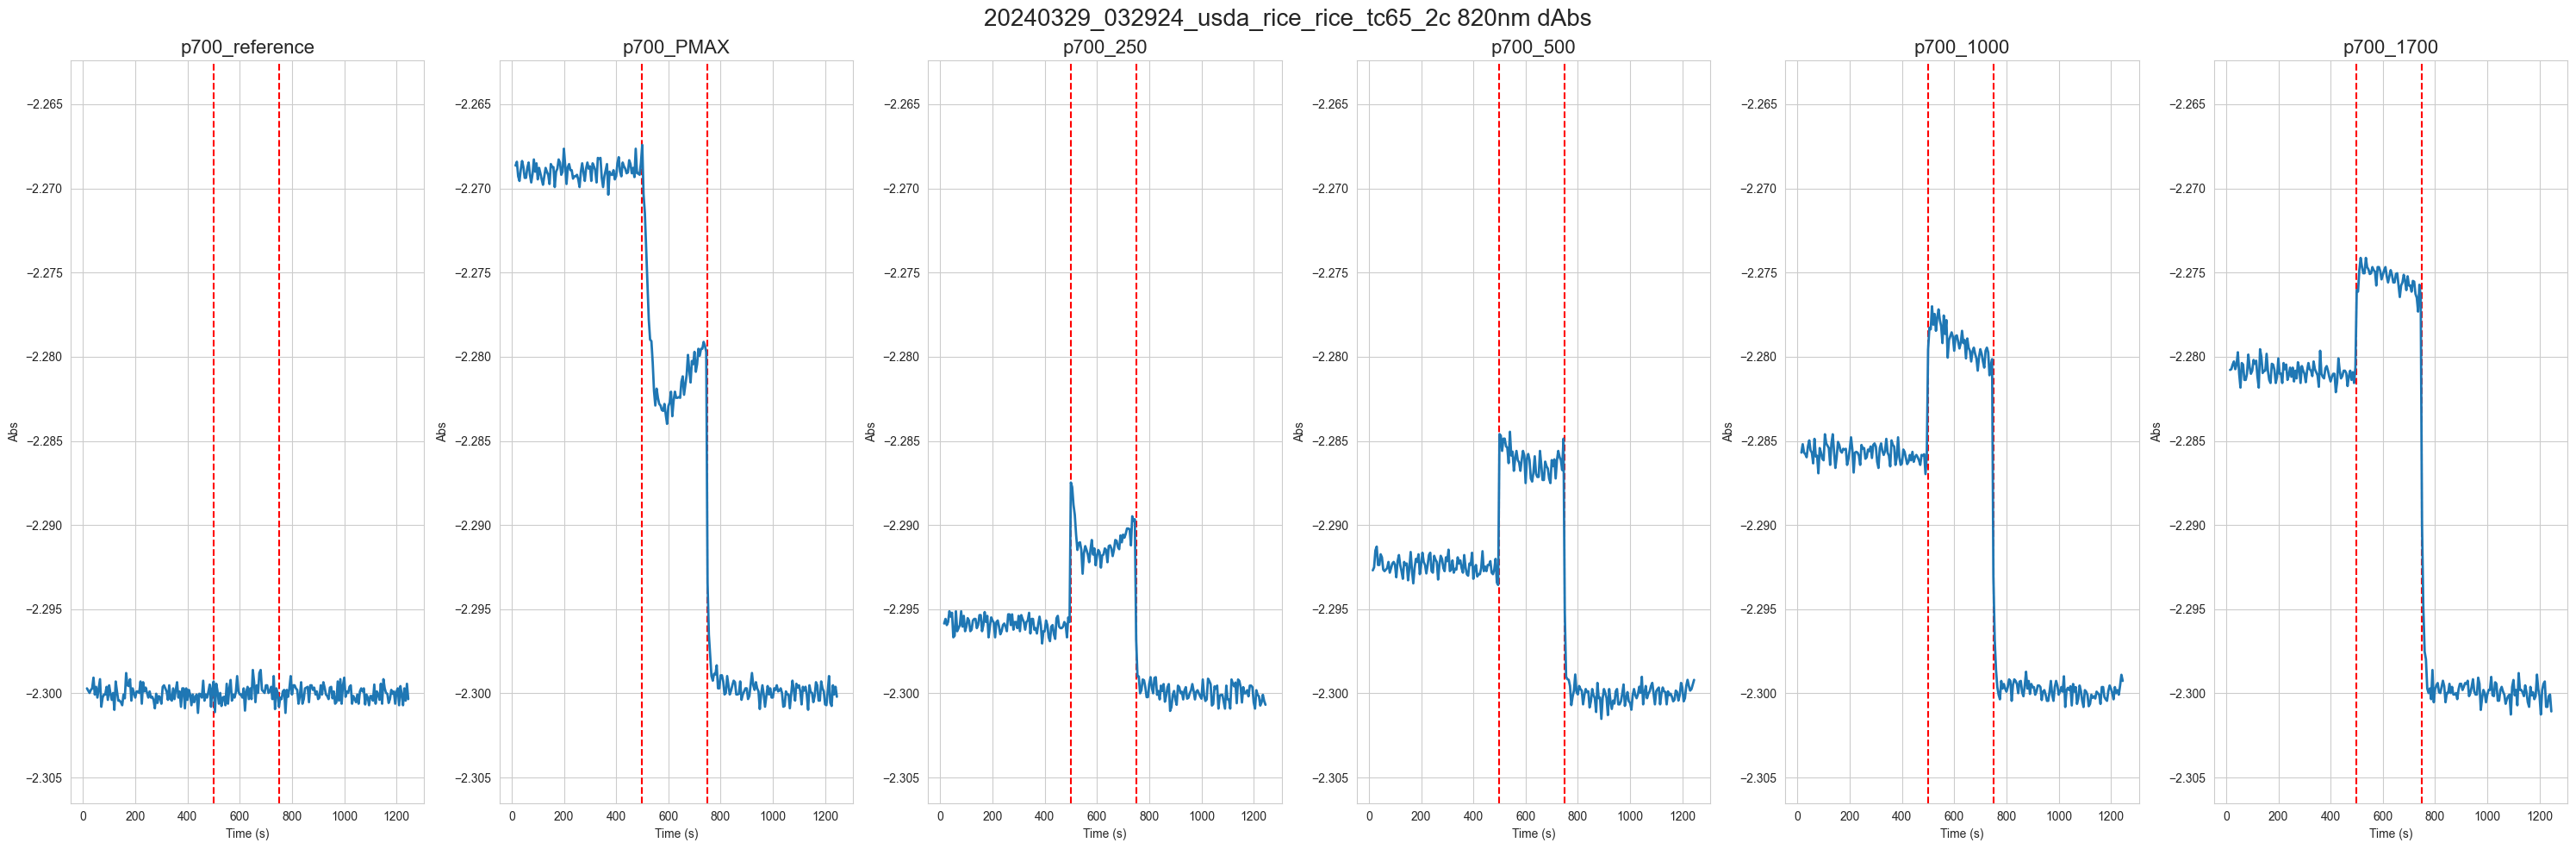

In [96]:
# take the non-normalized data, and calculate the dAbs for each label
data = pd.read_csv(f"output_data/{experiment_name}.csv")

# remove all points  less than  10 time_ms_trace
data = data[data["time_ms_trace"] > 10]


# check the true zero to see if we're going crazy
true_zero = data[data["labels"].str.contains("artifact")]["value"][0:100].mean()

# Filter by wavelength
data_fluor = data[data["wavelength"] == "530nm"]
data_p700 = data[data["wavelength"] == "820nm"]

# pulse start at 500ms and ends at 750ms
pulse_start = 500
pulse_end = 750


# Calculate dAbs for each label and save it in the DataFrame
for label in unique_labels:
    # Filter data for the current label
    label_data = data_p700[data_p700["labels"] == label].copy()

    # Calculate baseline for the current label
    baseline_value = calculate_baseline_for_label(
        label_data, -20, -5
    )

    # Calculate dAbs for each row in the label_data
    label_data["dAbs"] = calc_delta_absorbance(
        label_data["value"].values, baseline_value
    )

    # Update the main DataFrame (data_p700) with the calculated dAbs values for the current label
    data_p700.loc[data_p700["labels"] == label, "dAbs"] = label_data["dAbs"]

data_p700.to_csv(f"output_data/{experiment_name}_dAbs.csv")

# plot dAbs for 250
plt.figure(figsize=(30, 10))


# get the mean, max and min of the values
p700_min, p700_max = (
    data_p700["dAbs"].min() - 0.005,
    data_p700["dAbs"].max() + 0.005, 
)


for i, label in enumerate(unique_labels):

    ax = plt.subplot(1, len(data_p700["labels"].unique()), i + 1)
    label_data = data_p700[data_p700["labels"] == label].copy().reset_index(drop=True)

    print(len(label_data))

    # # set a vertical line
    ax.axvline(pulse_start, color="red", linestyle="--")
    ax.axvline(pulse_end, color="red", linestyle="--")

    sns.lineplot(
        x="time_ms_trace", y="dAbs", data=label_data, linestyle="-", linewidth=2
    )
    ax.set_title(f"{label}", fontsize=16)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Abs")
    
    ax.set_ylim(p700_min, p700_max)

plt.suptitle(f"{experiment_name} 820nm dAbs", fontsize=20)
plt.tight_layout()
plt.savefig(f"output_plots/{experiment_name}_820nm_dAbs.png")
plt.show()

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import Tuple

pm_start, pm_end = 485, 600
p_start, p_end = 250, 495
po_start, po_end = 1150, 1250

def get_p_vals(data: pd.DataFrame, x: str = "time_ms_trace", y: str = "dAbs") -> Tuple[float, float, float]:
    # Create a mask for rows where "time_ms_trace" is between 500 and 750
    pm_mask = (data[x] >= pm_start) & (data[x] <= pm_end)
    p_mask = (data[x] >= p_start) & (data[x] <= p_end)
    po_mask = (data[x] >= po_start) & (data[x] <= po_end)

    # Use the masks to filter the "ox_fraction" column and calculate the max and mean values
    Pmp = data.loc[pm_mask, y].max()
    P = data.loc[p_mask, y].dropna().mean()
    Po = data.loc[po_mask, y].mean()

    return (Pmp, P, Po)

data_p700 = pd.read_csv(f"output_data/{experiment_name}_dAbs.csv")

# normalize the data using the values from the pmax trace
pmax_df = data_p700[data_p700["labels"].str.contains("p700_PMAX")]

# calculate p values
Pm, P, Po = get_p_vals(pmax_df)
print(f"Pm: {Pm}, P: {P}, Po: {Po}")

data_p700["ox_fraction"] = (data_p700["dAbs"] - Po) / (Pm - Po)
data_p700.to_csv(f"output_data/{experiment_name}_dAbs_normalized.csv")

Pm: -2.2674158015188586, P: -2.2689521218888333, Po: -2.3000068301142704


label: p700_reference
label: p700_PMAX
label: p700_250
Pm: 1.0, Pmp: 0.3845813326542837, P: 0.12428518504047385, Po: -0.0035857165862486842
label: p700_500
Pm: 1.0, Pmp: 0.4771010769018672, P: 0.23130421554076558, Po: 0.003582705426840125
label: p700_1000
Pm: 1.0, Pmp: 0.7057772320431123, P: 0.4356525286416633, Po: 0.00393337384641335
label: p700_1700
Pm: 1.0, Pmp: 0.7940455201767267, P: 0.5834253240983456, Po: -0.00424363293257941


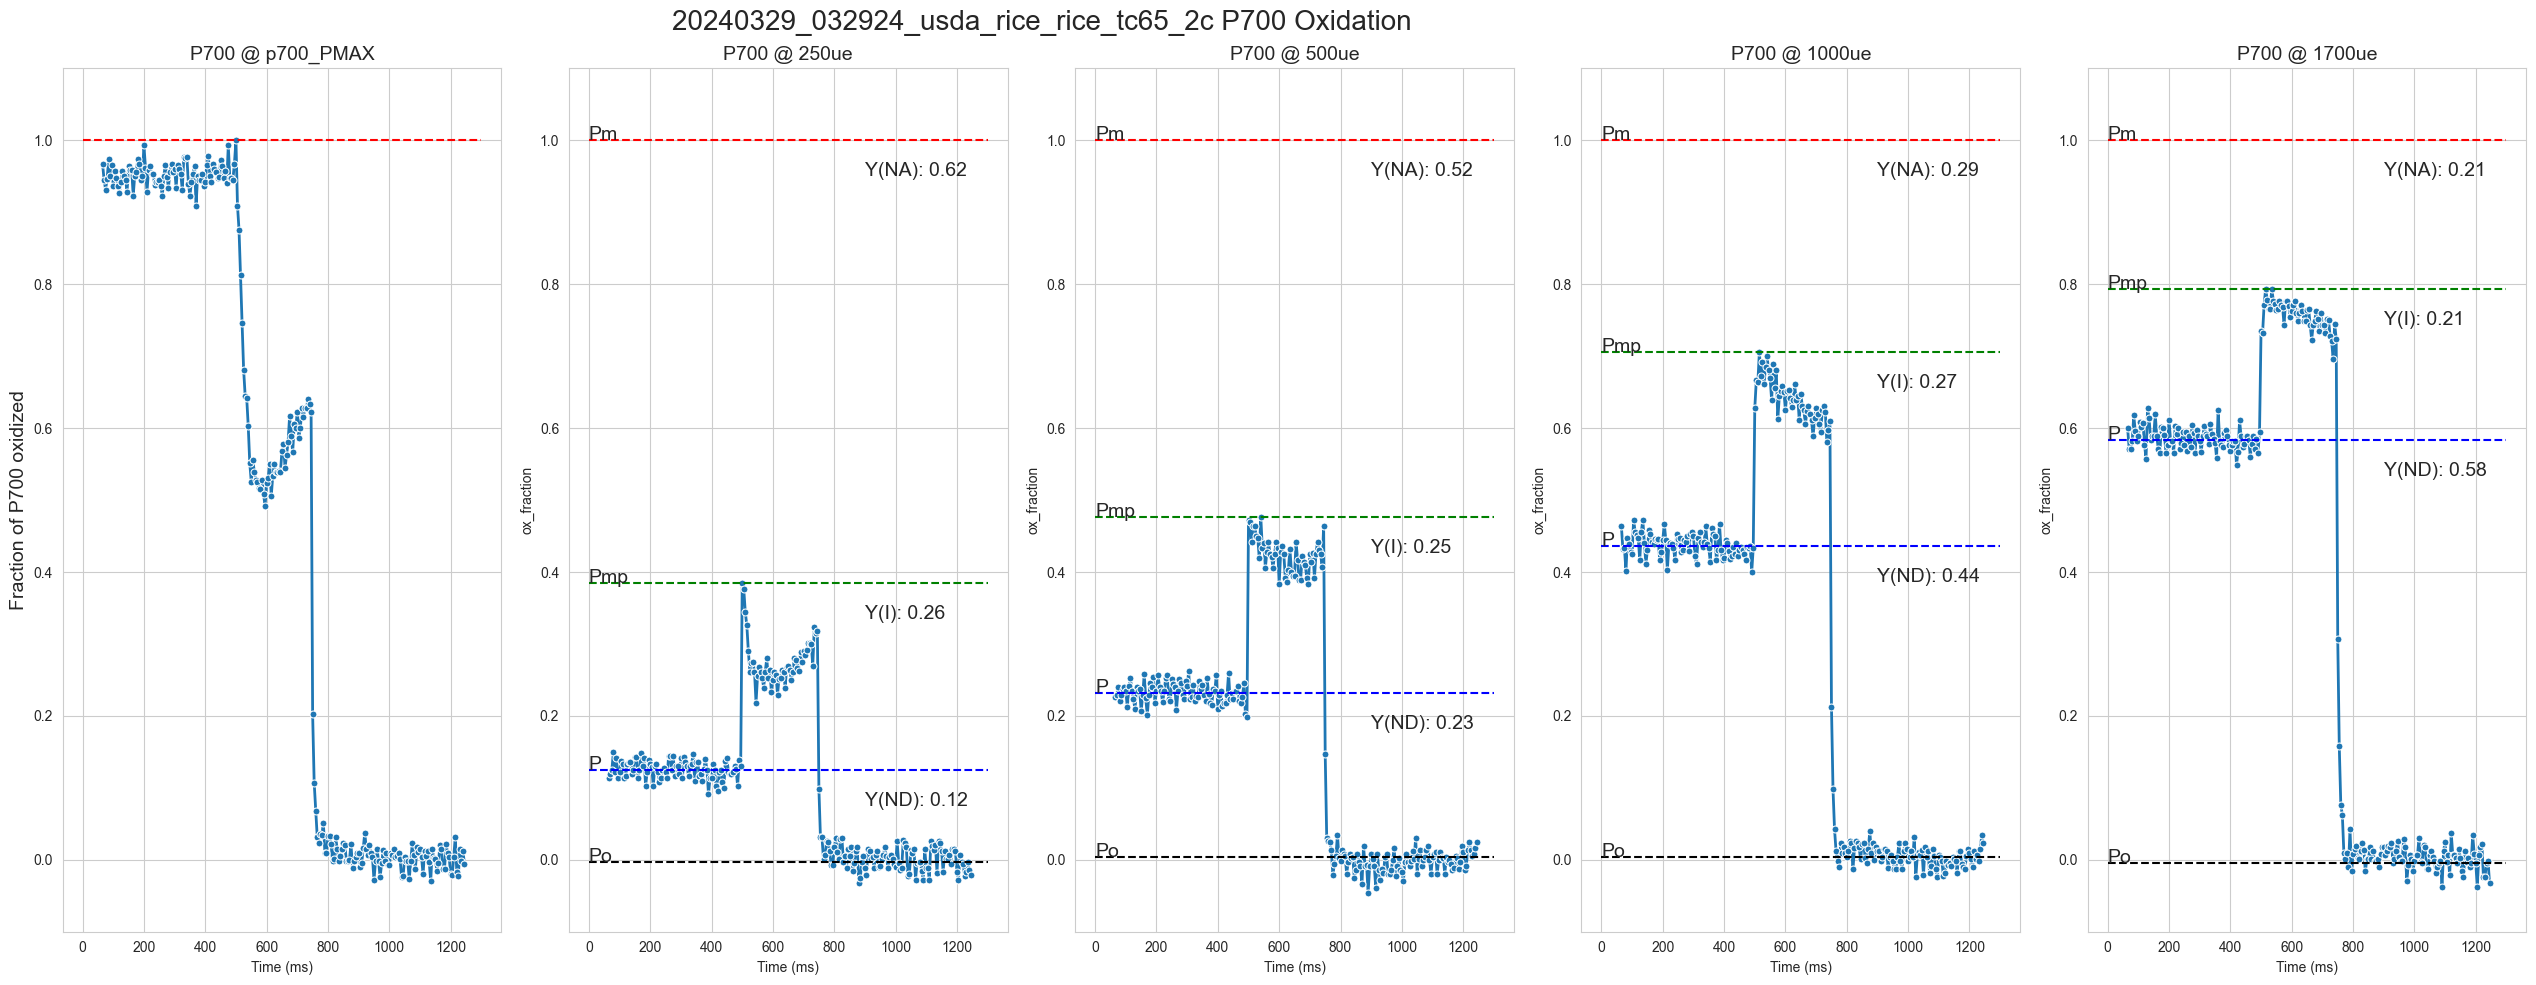

[{'ue': '250', 'Pm': 1.0, 'Pmp': 0.3845813326542837, 'P': 0.12428518504047385, 'Po': -0.0035857165862486842, 'Y(I)': 0.2602961476138098, 'Y(ND)': 0.12787090162672254, 'Y(NA)': 0.6154186673457163}, {'ue': '500', 'Pm': 1.0, 'Pmp': 0.4771010769018672, 'P': 0.23130421554076558, 'Po': 0.003582705426840125, 'Y(I)': 0.24579686136110163, 'Y(ND)': 0.22772151011392544, 'Y(NA)': 0.5228989230981328}, {'ue': '1000', 'Pm': 1.0, 'Pmp': 0.7057772320431123, 'P': 0.4356525286416633, 'Po': 0.00393337384641335, 'Y(I)': 0.27012470340144895, 'Y(ND)': 0.43171915479524997, 'Y(NA)': 0.29422276795688773}, {'ue': '1700', 'Pm': 1.0, 'Pmp': 0.7940455201767267, 'P': 0.5834253240983456, 'Po': -0.00424363293257941, 'Y(I)': 0.21062019607838112, 'Y(ND)': 0.587668957030925, 'Y(NA)': 0.2059544798232733}]


In [98]:
# take the normalized data and plot it, with the P values shown as horizontal lines
data_p700 = pd.read_csv(f"output_data/{experiment_name}_dAbs_normalized.csv")

# only if the wavelength is 820nm
data_p700 = data_p700[data_p700["wavelength"] == "820nm"]


# param locations in plot
param_x = 900

# list to save the P values
p_vals = []

# normalized data
plt.figure(figsize=(30, 10))
plt.suptitle(f"{experiment_name} P700 Oxidation", fontsize=20)

for i, label in enumerate(unique_labels):

    print(f"label: {label}")
    if ("reference" in label):
        continue

    if "PMAX" in label:
        title_label = f"P700 @ {label}"
    else:
        light_intensity = label.split("_")[-1]
        title_label = f"P700 @ {light_intensity}ue"

    ax = plt.subplot(1, len(data_p700["labels"].unique()), i + 1)
    label_data = data_p700[data_p700["labels"] == label]
    label_data = label_data.iloc[10:]
    label_data = label_data.reset_index(drop=True)

    if "PMAX" not in label:
        # calculate the Pmp, P, Po for all of the non-PMAX traces
        Pmp, P, Po = get_p_vals(label_data, x="time_ms_trace", y="ox_fraction")
        Pm = 1.0

        print(f"Pm: {Pm}, Pmp: {Pmp}, P: {P}, Po: {Po}")
        p_vals.append({"ue": light_intensity,
                        "Pm": Pm,
                        "Pmp": Pmp,
                        "P": P,
                        "Po": Po,
                        "Y(I)": Pmp - P,
                        "Y(ND)": P - Po,
                        "Y(NA)": Pm - Pmp
                        })

    # plot the normalized data as lines, with points as well   
    sns.lineplot(
        x="time_ms_trace",
        y="ox_fraction",
        data=label_data,
        linestyle="-",
        linewidth=2,
        markersize=5,
        marker="o",
    )



    # if the label is not PMAX, then plot these:
    if "PMAX" not in label:
        ax.hlines(Pm, 0, 1300, color="red", linestyle="--") # Pm
        ax.hlines(Pmp, 0, 1300, color="green", linestyle="--") # Pm'
        ax.hlines(P, 0, 1300, color="blue", linestyle="--") # P
        ax.hlines(Po, 0, 1300, color="black", linestyle="--") # Po

        # put a P next to the P line, a P' next to the P' line, etc
        ax.text(0, Pm, "Pm", fontsize=14)
        ax.text(0, Pmp, "Pmp", fontsize=14)
        ax.text(0, P, "P", fontsize=14)
        ax.text(0, Po, "Po", fontsize=14)
    else:
        ax.set_ylabel("Fraction of P700 oxidized", fontsize=14)
        ax.hlines(1, 0, 1300, color="red", linestyle="--")  # Everything is oxidized

    # now we need to add text annotations for the Y() values onto the plot, for each trace
    if "PMAX" not in label:
        ax.text(param_x, Pm - 0.05, f"Y(NA): {round(1 - Pmp, 2)}",fontsize=14, horizontalalignment="left")
        ax.text(param_x, Pmp - 0.05, f"Y(I): {round(Pmp - P, 2)}",fontsize=14, horizontalalignment="left")
        ax.text(param_x, P - 0.05, f"Y(ND): {round(P, 2)}", fontsize=14, horizontalalignment="left")
    ax.set_ylim(-0.1, 1.1) # set the y-axis limits, so we can see how the data changes from the normalized value
    ax.set_title(f"{title_label}", fontsize=14)
    ax.set_xlabel("Time (ms)")

plt.tight_layout()
plt.savefig(f"output_plots/{experiment_name}_p700_oxidation_normalized.png")
plt.show()

print(p_vals)

# create a dataframe of the p_vals, save it
p_vals_df = pd.DataFrame(p_vals)
p_vals_df.to_csv(f"output_data/{experiment_name}_p_vals.csv")

label: p700_reference
label: p700_PMAX
label: p700_250
Pm: 1.0, Pmp: 0.3845813326542837, P: 0.12428518504047385, Po: -0.0035857165862486842
label: p700_500
Pm: 1.0, Pmp: 0.4771010769018672, P: 0.23130421554076558, Po: 0.003582705426840125
label: p700_1000
Pm: 1.0, Pmp: 0.7057772320431123, P: 0.4356525286416633, Po: 0.00393337384641335
label: p700_1700
Pm: 1.0, Pmp: 0.7940455201767267, P: 0.5834253240983456, Po: -0.00424363293257941


C:\Users\magnus.wood\AppData\Local\Temp\ipykernel_32424\3200575422.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


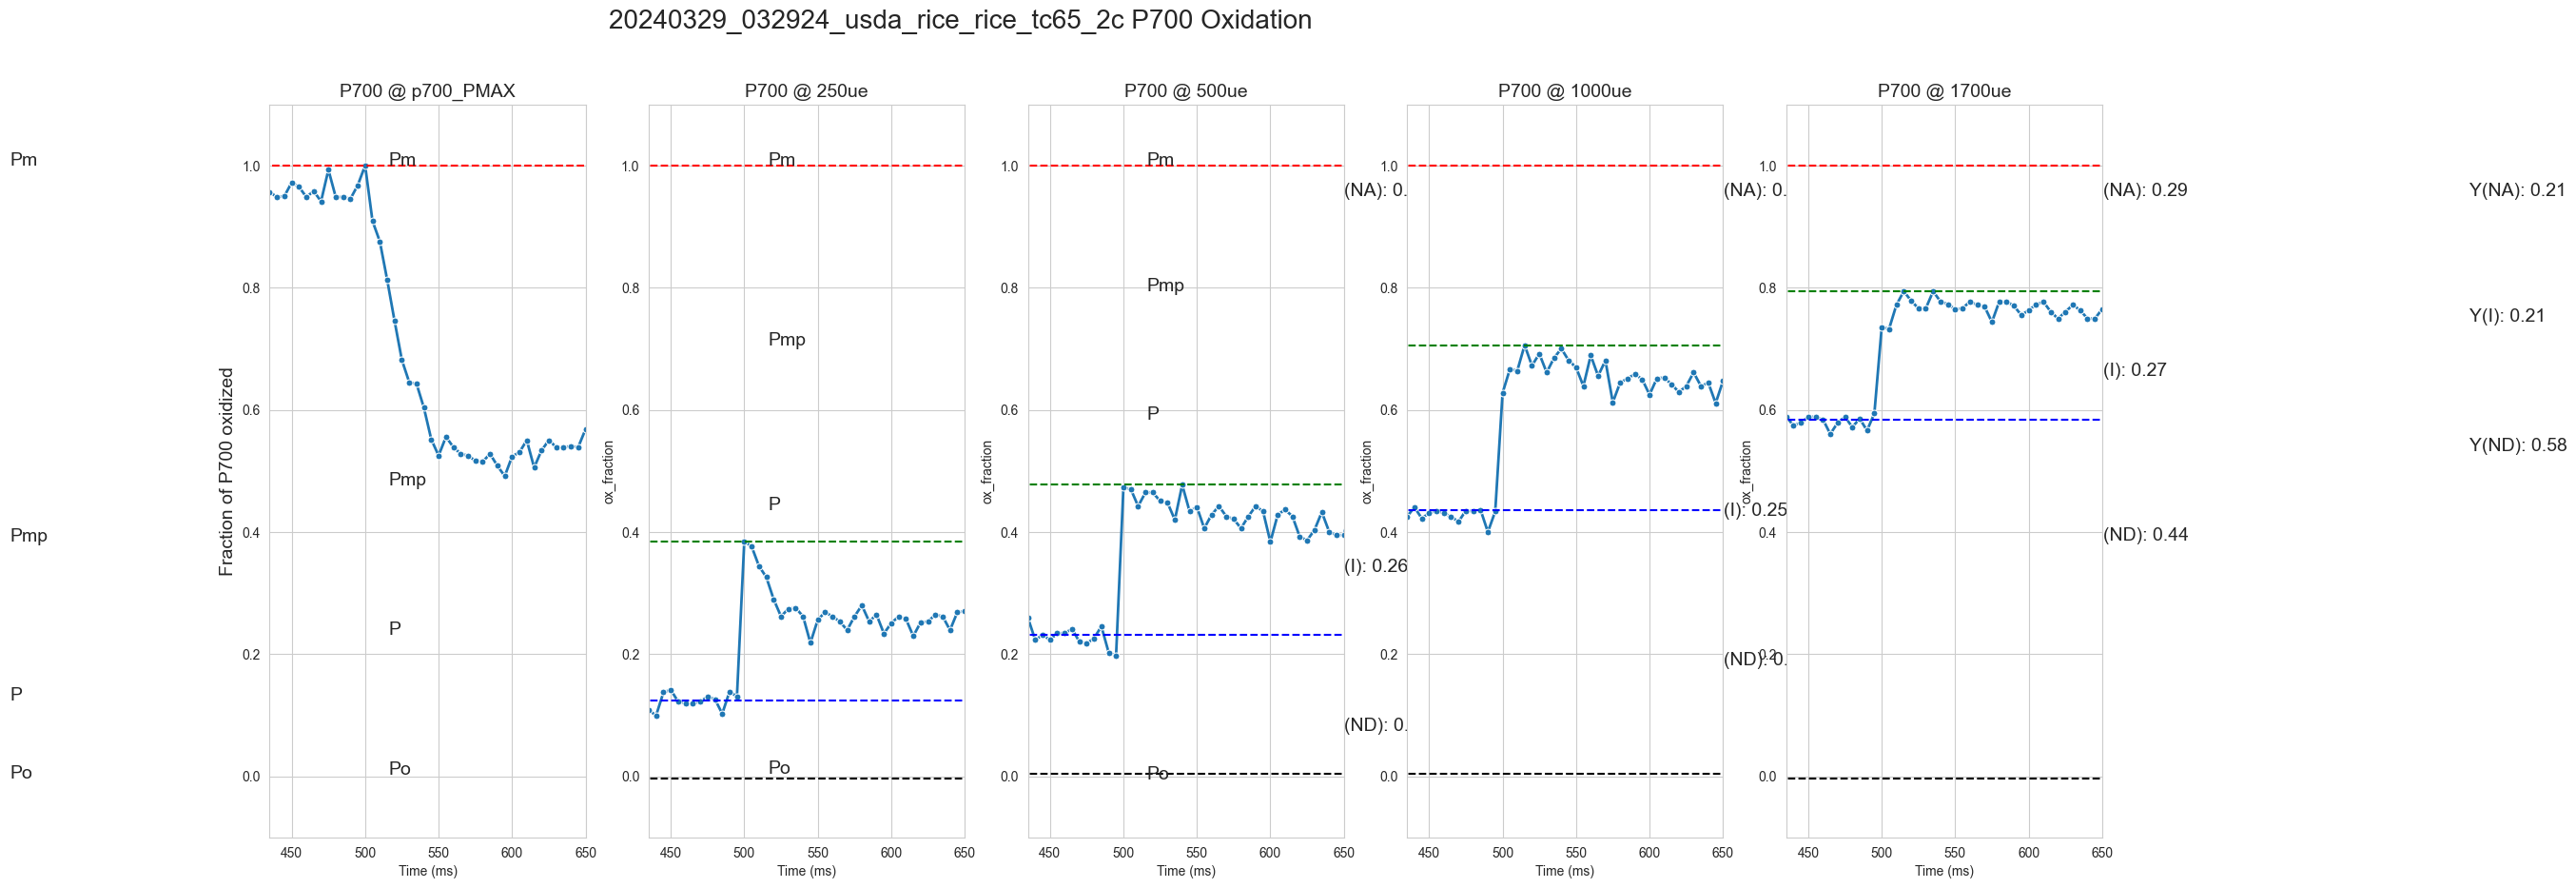

[{'ue': '250', 'Pm': 1.0, 'Pmp': 0.3845813326542837, 'P': 0.12428518504047385, 'Po': -0.0035857165862486842, 'Y(I)': 0.2602961476138098, 'Y(ND)': 0.12787090162672254, 'Y(NA)': 0.6154186673457163}, {'ue': '500', 'Pm': 1.0, 'Pmp': 0.4771010769018672, 'P': 0.23130421554076558, 'Po': 0.003582705426840125, 'Y(I)': 0.24579686136110163, 'Y(ND)': 0.22772151011392544, 'Y(NA)': 0.5228989230981328}, {'ue': '1000', 'Pm': 1.0, 'Pmp': 0.7057772320431123, 'P': 0.4356525286416633, 'Po': 0.00393337384641335, 'Y(I)': 0.27012470340144895, 'Y(ND)': 0.43171915479524997, 'Y(NA)': 0.29422276795688773}, {'ue': '1700', 'Pm': 1.0, 'Pmp': 0.7940455201767267, 'P': 0.5834253240983456, 'Po': -0.00424363293257941, 'Y(I)': 0.21062019607838112, 'Y(ND)': 0.587668957030925, 'Y(NA)': 0.2059544798232733}]


In [99]:
# take the normalized data and plot it, with the P values shown as horizontal lines
data_p700 = pd.read_csv(f"output_data/{experiment_name}_dAbs_normalized.csv")

# only if the wavelength is 820nm
data_p700 = data_p700[data_p700["wavelength"] == "820nm"]


# param locations in plot
param_x = 900

# list to save the P values
p_vals = []

# normalized data
plt.figure(figsize=(30, 10))
plt.suptitle(f"{experiment_name} P700 Oxidation", fontsize=20)

for i, label in enumerate(unique_labels):

    print(f"label: {label}")
    if ("reference" in label):
        continue

    if "PMAX" in label:
        title_label = f"P700 @ {label}"
    else:
        light_intensity = label.split("_")[-1]
        title_label = f"P700 @ {light_intensity}ue"

    ax = plt.subplot(1, len(data_p700["labels"].unique()), i + 1)
    label_data = data_p700[data_p700["labels"] == label]
    label_data = label_data.iloc[10:]
    label_data = label_data.reset_index(drop=True)

    if "PMAX" not in label:
        # calculate the Pmp, P, Po for all of the non-PMAX traces
        Pmp, P, Po = get_p_vals(label_data, x="time_ms_trace", y="ox_fraction")
        Pm = 1.0

        print(f"Pm: {Pm}, Pmp: {Pmp}, P: {P}, Po: {Po}")
        p_vals.append({"ue": light_intensity,
                        "Pm": Pm,
                        "Pmp": Pmp,
                        "P": P,
                        "Po": Po,
                        "Y(I)": Pmp - P,
                        "Y(ND)": P - Po,
                        "Y(NA)": Pm - Pmp
                        })

    # plot the normalized data as lines, with points as well   
    sns.lineplot(
        x="time_ms_trace",
        y="ox_fraction",
        data=label_data,
        linestyle="-",
        linewidth=2,
        markersize=5,
        marker="o",
    )

    ax.set_xlim(pm_start - 50, pm_end + 50)


    # if the label is not PMAX, then plot these:
    if "PMAX" not in label:
        ax.hlines(Pm, 0, 1300, color="red", linestyle="--") # Pm
        ax.hlines(Pmp, 0, 1300, color="green", linestyle="--") # Pm'
        ax.hlines(P, 0, 1300, color="blue", linestyle="--") # P
        ax.hlines(Po, 0, 1300, color="black", linestyle="--") # Po

        # put a P next to the P line, a P' next to the P' line, etc
        ax.text(0, Pm, "Pm", fontsize=14)
        ax.text(0, Pmp, "Pmp", fontsize=14)
        ax.text(0, P, "P", fontsize=14)
        ax.text(0, Po, "Po", fontsize=14)
    else:
        ax.set_ylabel("Fraction of P700 oxidized", fontsize=14)
        ax.hlines(1, 0, 1300, color="red", linestyle="--")  # Everything is oxidized

    # now we need to add text annotations for the Y() values onto the plot, for each trace
    if "PMAX" not in label:
        ax.text(param_x, Pm - 0.05, f"Y(NA): {round(1 - Pmp, 2)}",fontsize=14, horizontalalignment="left")
        ax.text(param_x, Pmp - 0.05, f"Y(I): {round(Pmp - P, 2)}",fontsize=14, horizontalalignment="left")
        ax.text(param_x, P - 0.05, f"Y(ND): {round(P, 2)}", fontsize=14, horizontalalignment="left")
    ax.set_ylim(-0.1, 1.1) # set the y-axis limits, so we can see how the data changes from the normalized value
    ax.set_title(f"{title_label}", fontsize=14)
    ax.set_xlabel("Time (ms)")

plt.tight_layout()
plt.savefig(f"output_plots/{experiment_name}_p700_oxidation_normalized_zoom.png")
plt.show()

print(p_vals)

# create a dataframe of the p_vals, save it
p_vals_df = pd.DataFrame(p_vals)
p_vals_df.to_csv(f"output_data/{experiment_name}_p_vals.csv")

### TODO:

Calculate p' whichever is higher, last few datapoints of p or a mean of the first few datapoints during the pulse

### adjust the pmax calculation

Either take the mean of the first few points of the pulse, or the mean of the last few points of the prepulse, whichever is higher.

In [100]:
# load the p_vals dataframe
p_vals_df = pd.read_csv(f"output_data/{experiment_name}_p_vals.csv")
p_vals_df = p_vals_df.drop(columns=["Unnamed: 0"])

# load the fluor data as well
fluor_df = pd.read_csv(f"output_data/{experiment_name}_fluor.csv")
fluor_df = fluor_df.drop(columns=["Unnamed: 0"]).transpose()

# drop all rows that have label including "reference"
fluor_df = fluor_df[~fluor_df.index.str.contains("reference")]

# index to column
fluor_df = fluor_df.reset_index()

# rename the columns
fluor_df.columns = ["ue", "value"]

# extract the fvfm value for later use
fvfm = fluor_df[fluor_df["ue"] == "fvfm"]["value"].values[0]

# slice teh dataframe to get all ue that are not fvfm
fluor_df = fluor_df[fluor_df["ue"] != "fvfm"]

# convert the ue column to int64
fluor_df["ue"] = fluor_df["ue"].astype("int64").copy()

# value is now the Phi2 value
p_vals_df["PhiII"] = fluor_df["value"].values
p_vals_df["FvFm"] = fvfm
p_vals_df.head()

,ue,Pm,Pmp,P,Po,Y(I),Y(ND),Y(NA),PhiII,FvFm
0,250,1.0,0.384581,0.124285,-0.003586,0.260296,0.127871,0.615419,0.66,0.86
1,500,1.0,0.477101,0.231304,0.003583,0.245797,0.227722,0.522899,0.58,0.86
2,1000,1.0,0.705777,0.435653,0.003933,0.270125,0.431719,0.294223,0.46,0.86
3,1700,1.0,0.794046,0.583425,-0.004244,0.210620,0.587669,0.205954,0.35,0.86


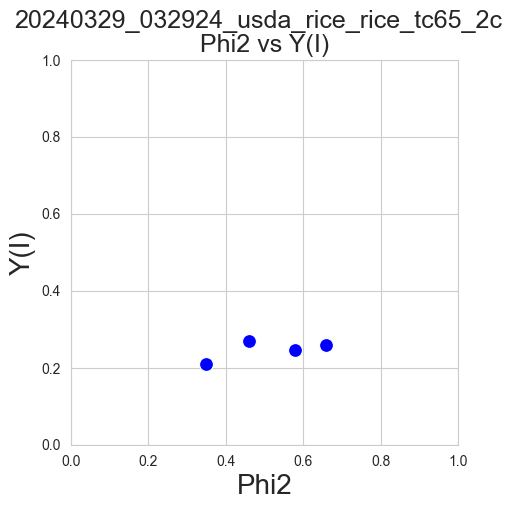

,ue,Pm,Pmp,P,Po,Y(I),Y(ND),Y(NA),PhiII,FvFm
0,250,1.0,0.384581,0.124285,-0.003586,0.260296,0.127871,0.615419,0.66,0.86
1,500,1.0,0.477101,0.231304,0.003583,0.245797,0.227722,0.522899,0.58,0.86
2,1000,1.0,0.705777,0.435653,0.003933,0.270125,0.431719,0.294223,0.46,0.86
3,1700,1.0,0.794046,0.583425,-0.004244,0.210620,0.587669,0.205954,0.35,0.86


In [101]:
# Now plot Phi2 vs Y(I)
plt.figure(figsize=(5, 5))
plt.ylim(0, 1)
plt.xlim(0, 1)

# plot the Phi2 vs Y(I)
sns.scatterplot(x="PhiII", y="Y(I)", data=p_vals_df, s=100, color="blue")

# add a title and labels
plt.suptitle(f"{experiment_name}", fontsize=18)
plt.title(f"Phi2 vs Y(I)", fontsize=18)

# add labels
plt.xlabel("Phi2", fontsize=20)
plt.ylabel("Y(I)", fontsize=20)

plt.savefig(f"output_plots/{experiment_name}_Phi2_vs_YI.png")
plt.show()
p_vals_df.head()

In [102]:
# params for the p700 traces
params = {}

# calc pmax first
pmax_df = data_p700[data_p700["labels"] == "p700_PMAX"]
params["Pm"] = pmax_df["dAbs"].iloc[-150:-140].mean()
params["Po"] = pmax_df["dAbs"].iloc[-20:].mean()

for label in data_p700["labels"].unique():

    if "PMAX" not in label and "refer" not in label:
        print(f"label: {label}")
        df = data_p700[data_p700["labels"] == label]

        params[label] = {
            "phi2": calculate_fvfm(data_fluor[data_fluor["labels"] == label], 100, 150),
            "P": df["dAbs"].iloc[-170:-150].mean(),
            "Pmp": df["dAbs"].iloc[-150:-140].mean(),
            "Po": df["dAbs"].iloc[-20:].mean(),
        }

print(params)

label: p700_1700
label: p700_250
label: p700_1000
label: p700_500
{'Pm': -2.275671132967477, 'Po': -2.3000068301142704, 'p700_1700': {'phi2': 0.33, 'P': -2.2811264391208277, 'Pmp': -2.27494872553891, 'Po': -2.3001451344765242}, 'p700_250': {'phi2': 0.64, 'P': -2.2960759943884805, 'Pmp': -2.290191124243956, 'Po': -2.300123692306068}, 'p700_1000': {'phi2': 0.46, 'P': -2.2860364760526553, 'Pmp': -2.2779924122001054, 'Po': -2.2998786374147655}, 'p700_500': {'phi2': 0.58, 'P': -2.292666268904682, 'Pmp': -2.285199100750254, 'Po': -2.299890066059255}}


In [103]:
def remove_y_axis(ax):
    # Remove tick marks and labels from the y-axis
    ax.set_ylabel("")
    ax.set_yticklabels([])

## Look at the time series of the Fluorescence

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns


def calculate_fvfm(data, pulse_start, pulse_end):
    # Calculate Fv/Fm
    # Fv = Fm - Fo
    # Fm = max fluorescence
    # Fo = minimal fluorescence
    # Fv/Fm = (Fm - Fo) / Fm    # Fo is the minimal fluorescence measured in the dark-adapted state

    # halfway through the pulse,
    pulse_midpoint = pulse_start + ((pulse_end - pulse_start) // 2)
    prepulse_midpoint = pulse_start // 2

    # reindex the data
    data = data.copy().reset_index(drop=True)

    Fo = data.iloc[pulse_start -5 : pulse_start]["value"].mean()
    Fm = data.iloc[pulse_midpoint : pulse_end - 5]["value"].mean()
    FvFm = round((Fm - Fo) / Fm, 2)
    print(f"Fo: {Fo}, Fm: {Fm}, Fv/Fm: {FvFm}")

    return round((Fm - Fo) / Fm, 2)  # two decimal places is fine


data_csv_fluor_2 = pd.read_csv(f"output_data/{experiment_name}.csv")

# Filter by wavelength
data_green = data_csv_fluor_2[data_csv_fluor_2["wavelength"] == "530nm"]


# sort for the order of the traces
sorted_labels = sorted(data_green["labels"].unique())

sorted_labels = [
    label
    for label in sorted_labels
    if ("fvfm" in label or "p700" in label or "fluor" in label) and ("PMAX" not in label)
]

unique_labels = []
light_labels = []

for label in sorted_labels:
    if "p700" in label:
        light_labels.append(label)
    else:
        unique_labels.append(label)

sorted_labels = sorted(light_labels, key=lambda x: int(x.split("_")[-1]))

unique_labels.extend(sorted_labels)

print(unique_labels)


['fluor_reference', 'fvfm', 'p700_250', 'p700_500', 'p700_1000', 'p700_1700']


Fo: 21.0, Fm: 19.65, Fv/Fm: -0.07
Fo: 19.2, Fm: 139.1, Fv/Fm: 0.86
Fo: 32.2, Fm: 86.7, Fv/Fm: 0.63
Fo: 30.6, Fm: 76.25, Fv/Fm: 0.6
Fo: 33.2, Fm: 68.65, Fv/Fm: 0.52
Fo: 45.0, Fm: 68.15, Fv/Fm: 0.34


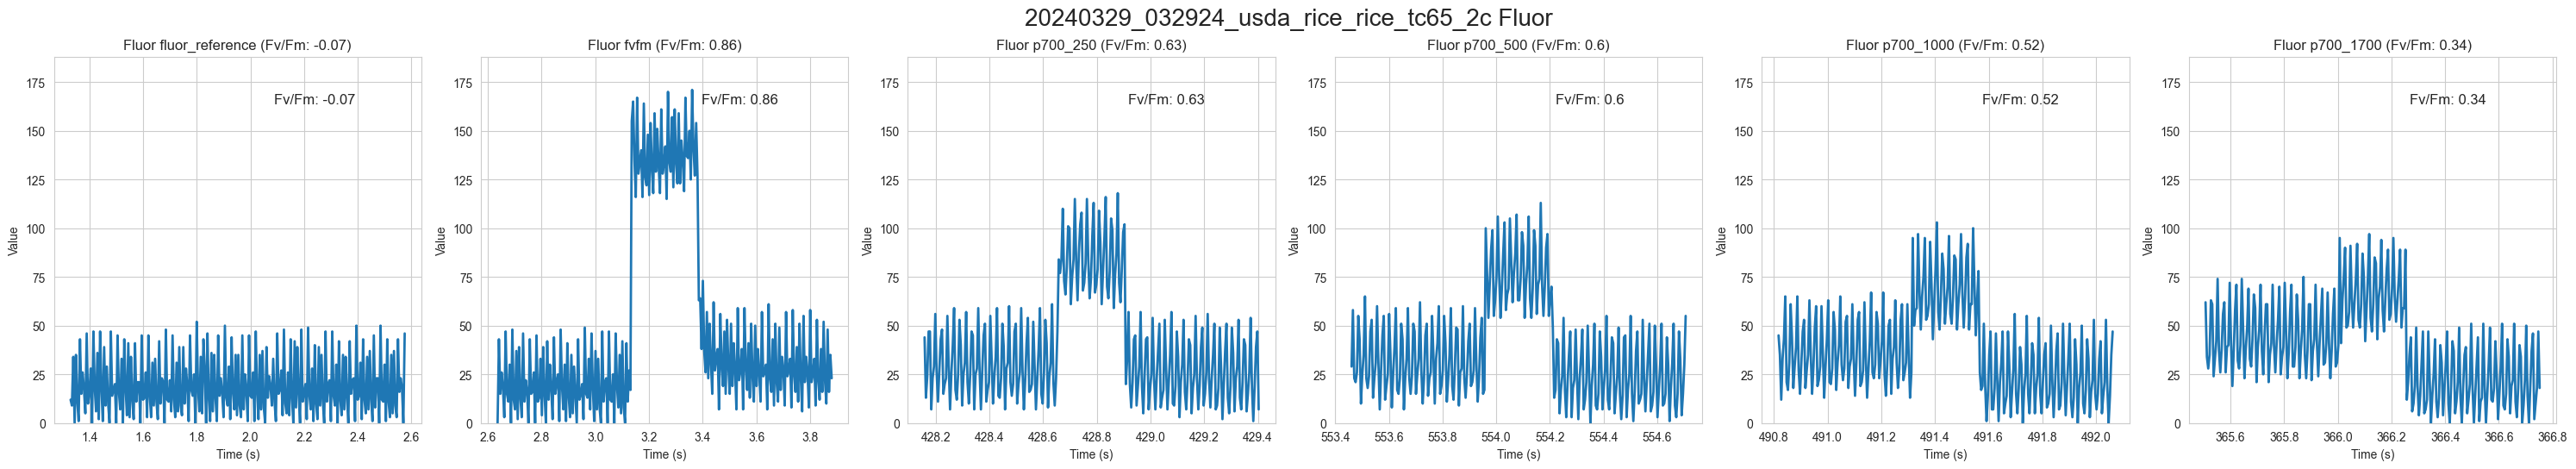

In [105]:
unique_labels_green = unique_labels
plt.figure(figsize=(30, 10))

# get the ylim values for the fvfm trace, by finding the max value for the "value" column where the label == "fvfm"
label_data = data_green[data_green["labels"] == "fvfm"]
ylim = [0, np.max(label_data["value"]) * 1.1]

# Plot green data
for i, label in enumerate(unique_labels_green):
    

    ax = plt.subplot(2, len(unique_labels_green), i + 1)
    label_data = data_green[data_green["labels"] == label]
    fvfm = calculate_fvfm(label_data, 100, 150)
    sns.lineplot(x="time_s", y="value", data=label_data, linestyle="-", linewidth=2)
    ax.set_title(f"Fluor {label} (Fv/Fm: {fvfm})")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Value")
    

    # else:
    #     remove_y_axis(ax)
        
    ax.set_ylim(ylim[0], ylim[1])
    
    # Add Fv/Fm text annotation within the plot
    ax.text(
        0.6,
        0.9,
        f"Fv/Fm: {fvfm}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
    )

plt.suptitle(f"{experiment_name} Fluor", fontsize=20)

plt.tight_layout()
plt.savefig(f"output_plots/{experiment_name}_fluor.png")
plt.show()

# c